In [1]:
import sys, os

In [2]:
sys.path += ["../../external"]

In [3]:
%load_ext autoreload
%autoreload 1
%aimport zero_order_gpmpc

In [4]:
import numpy as np
from scipy.stats import norm
import casadi as cas
from acados_template import (
    AcadosOcp,
    AcadosSim,
    AcadosSimSolver,
    AcadosOcpSolver,
    AcadosOcpOptions,
)
import matplotlib.pyplot as plt
import torch
import gpytorch
import copy

# zoRO imports
import zero_order_gpmpc
from zero_order_gpmpc.controllers import (
    ZoroAcados,
    ZoroAcadosCustomUpdate,
    ResidualLearningMPC,
)
from inverted_pendulum_model_acados import (
    export_simplependulum_ode_model,
    export_ocp_nominal,
)
from utils import base_plot, add_plot_trajectory, EllipsoidTubeData2D

# gpytorch_utils
from gpytorch_utils.gp_hyperparam_training import (
    generate_train_inputs_acados,
    generate_train_outputs_at_inputs,
    train_gp_model,
)
from gpytorch_utils.gp_utils import (
    gp_data_from_model_and_path,
    gp_derivative_data_from_model_and_path,
    plot_gp_data,
    generate_grid_points,
)
from zero_order_gpmpc.models.gpytorch_models.gpytorch_gp import (
    BatchIndependentMultitaskGPModel,
)


## Define model parameters

We model the inverted pendulum

$$
\dot{x} = f(x,u) = \begin{bmatrix} \dot{\theta} \\ \ddot{\theta} \end{bmatrix} = \begin{bmatrix} \dot{\theta} \\ -\sin(\theta) + u \end{bmatrix},
$$

which is to be controlled from the hanging-down resting position, $(\theta_0, \dot{\theta}_0) = (\pi, 0)$, to the upright position ($(\theta_r, \dot{\theta}_r) = (0,0)$), subject to the constraints that overshoot should be avoided, i.e.,

$$
\theta_{lb} \leq \theta \leq \theta_{ub}.
$$

The model setup and controller definition can be found in the functions `export_simplependulum_ode_model()`, `export_ocp_nominal()` in the `inverted_pendulum_model_acados.py` file.

In [5]:
# build C code again?
build_c_code = True

In [6]:
# discretization
N = 30
T = 5
dT = T / N

# constraints
x0 = np.array([np.pi, 0])
nx = 2
nu = 1

In [7]:
prob_x = 0.9
prob_tighten = norm.ppf(prob_x)

# noise
# uncertainty dynamics
sigma_theta = (0.0001 / 360.0) * 2 * np.pi
sigma_omega = (0.0001 / 360.0) * 2 * np.pi
w_theta = 0.03
w_omega = 0.03
Sigma_x0 = np.array([[sigma_theta**2, 0], [0, sigma_omega**2]])
Sigma_W = np.array([[w_theta**2, 0], [0, w_omega**2]])

## Set up nominal solver

In [8]:
ocp_init = export_ocp_nominal(N, T, only_lower_bounds=True)
ocp_init.solver_options.nlp_solver_type = "SQP"

acados_ocp_init_solver = AcadosOcpSolver(
    ocp_init, json_file="acados_ocp_init_simplependulum_ode.json"
)

 If there is an incompatibility with the CasADi generated code, please consider changing your CasADi version.
Version 3.6.5 currently in use.
rm -f libacados_ocp_solver_simplependulum_ode.so
rm -f simplependulum_ode_constraints/simplependulum_ode_constr_h_fun_jac_uxt_zt.o simplependulum_ode_constraints/simplependulum_ode_constr_h_fun.o acados_solver_simplependulum_ode.o
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/hpipm/include  -c -o simplependulum_ode_constraints/simplependulum_ode_constr_h_fun_jac_uxt_zt.o simplependulum_ode_constraints/simplependulum_ode_constr_h_fun_jac_uxt_zt.c
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/z

## Open-loop planning with nominal solver

In [9]:
# get initial values
X_init = np.zeros((N + 1, nx))
U_init = np.zeros((N, nu))

# xcurrent = x0
X_init[0, :] = x0

# solve
status_init = acados_ocp_init_solver.solve()

if status_init != 0:
    raise Exception(
        "acados acados_ocp_solver returned status {}. Exiting.".format(status_init)
    )

# get data
for i in range(N):
    X_init[i, :] = acados_ocp_init_solver.get(i, "x")
    U_init[i, :] = acados_ocp_init_solver.get(i, "u")

X_init[N, :] = acados_ocp_init_solver.get(N, "x")

In [10]:
import re

In [11]:
# integrator for nominal model
sim = AcadosSim()

sim.model = ocp_init.model
sim.parameter_values = ocp_init.parameter_values

for opt_name in dir(ocp_init.solver_options):
    if opt_name in dir(sim.solver_options) and re.search(r"__.*?__", opt_name) is None:
        if opt_name == "sim_method_jac_reuse":
            set_value = int(getattr(ocp_init.solver_options, opt_name)[0])
        else:
            set_value = getattr(ocp_init.solver_options, opt_name)
        print(f"Setting {opt_name} to {set_value}")
        setattr(sim.solver_options, opt_name, set_value)

sim.solver_options.T = ocp_init.solver_options.Tsim
acados_integrator = AcadosSimSolver(
    sim, json_file="acados_sim_" + sim.model.name + ".json"
)

Setting collocation_type to GAUSS_LEGENDRE
Setting ext_fun_compile_flags to -O2
Setting integrator_type to ERK
Setting sim_method_jac_reuse to 0
 If there is an incompatibility with the CasADi generated code, please consider changing your CasADi version.
Version 3.6.5 currently in use.
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/hpipm/include  -c -o acados_sim_solver_simplependulum_ode.o acados_sim_solver_simplependulum_ode.c
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/acados -I

## Simulator object

To automatically discretize the model (and obtain sensitivities of the discrete-time model) within the zero-order implementation, we create the `AcadosSimSolver` object to pass to the solver.

In [12]:
# generate training data for GP with augmented model
# "real model"
model_actual = export_simplependulum_ode_model()
model_actual.f_expl_expr = model_actual.f_expl_expr + cas.vertcat(
    cas.DM(0), -0.5 * cas.sin((model_actual.x[0]) ** 2)
)
model_actual.f_impl_expr = model_actual.xdot - model_actual.f_expl_expr
model_actual.name = model_actual.name + "_actual"

# acados integrator
sim_actual = AcadosSim()
sim_actual.model = model_actual
sim_actual.solver_options.integrator_type = "ERK"

# set prediction horizon
sim_actual.solver_options.T = dT

# acados_ocp_solver = AcadosOcpSolver(ocp, json_file = 'acados_ocp_' + model.name + '.json')
acados_integrator_actual = AcadosSimSolver(
    sim_actual, json_file="acados_sim_" + model_actual.name + ".json"
)

 If there is an incompatibility with the CasADi generated code, please consider changing your CasADi version.
Version 3.6.5 currently in use.
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/hpipm/include  -c -o acados_sim_solver_simplependulum_ode_actual.o acados_sim_solver_simplependulum_ode_actual.c
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/blasfeo/include -I/home/amon/Repositories/ze

## Simulation results (nominal)

In [13]:
X_init_sim = np.zeros_like(X_init)
X_init_sim[0, :] = x0
for i in range(N):
    acados_integrator_actual.set("x", X_init_sim[i, :])
    acados_integrator_actual.set("u", U_init[i, :])
    acados_integrator_actual.solve()
    X_init_sim[i + 1, :] = acados_integrator_actual.get("x")

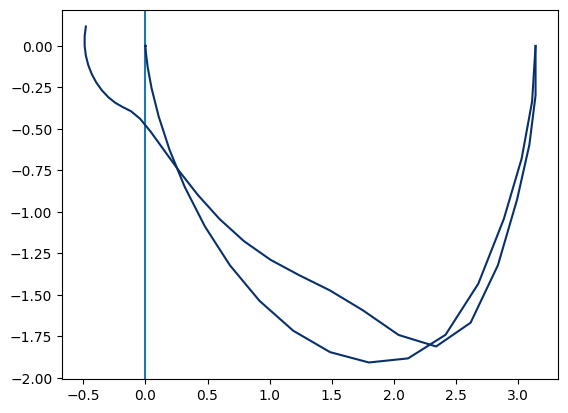

In [14]:
lb_theta = -ocp_init.constraints.lh[0]
fig, ax = base_plot(lb_theta=lb_theta)

plot_data_nom = EllipsoidTubeData2D(center_data=X_init, ellipsoid_data=None)
plot_data_nom_sim = EllipsoidTubeData2D(center_data=X_init_sim, ellipsoid_data=None)
add_plot_trajectory(ax, plot_data_nom, prob_tighten=None, color_fun=plt.cm.Blues)
add_plot_trajectory(ax, plot_data_nom_sim, prob_tighten=None, color_fun=plt.cm.Blues)

# GP training

We use a model with different parameters to emulate the real-world model and obtain some training data. Also create simulator object for real-world model to evaluate our results later (not used in solver).

## Generate training data

We generate training data (one-step ahead residuals `y_train` for starting point `x_train`) here by running robustified (cautious) solver without GP.

In [15]:
random_seed = 123
N_sim_per_x0 = 1
N_x0 = 10
x0_rand_scale = 0.1

x_train, x0_arr = generate_train_inputs_acados(
    acados_ocp_init_solver,
    x0,
    N_sim_per_x0,
    N_x0,
    random_seed=random_seed,
    x0_rand_scale=x0_rand_scale,
)

y_train = generate_train_outputs_at_inputs(
    x_train, acados_integrator, acados_integrator_actual, Sigma_W
)

## Hyper-parameter training for GP model

Optimize hyper-parameters of GP model (kernel function parameters, ...)

In [16]:
x_train_tensor = torch.Tensor(x_train)
y_train_tensor = torch.Tensor(y_train)
nout = y_train.shape[1]

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=nout)
gp_model = BatchIndependentMultitaskGPModel(x_train_tensor, y_train_tensor, likelihood)

In [17]:
training_iterations = 200
rng_seed = 456

gp_model, likelihood = train_gp_model(
    gp_model, torch_seed=rng_seed, training_iterations=training_iterations
)

# EVAL MODE
gp_model.eval()
likelihood.eval()

Iter 20/200 - Loss: 0.634
Iter 40/200 - Loss: -0.381
Iter 60/200 - Loss: -1.334
Iter 80/200 - Loss: -1.929
Iter 100/200 - Loss: -2.042
stopping GP optimization early after 105 iterations.


MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

## Plot GP predictions

We plot GP predictions along the predicted trajectory of the robustified solver by projecting the multivariate plot down to a line.

In [18]:
x_train.shape, y_train.shape

((300, 3), (300, 2))

(<Figure size 800x600 with 2 Axes>,
 array([<Axes: title={'center': 'Observed Values (Likelihood), output 0'}>,
        <Axes: title={'center': 'Observed Values (Likelihood), output 1'}>],
       dtype=object))

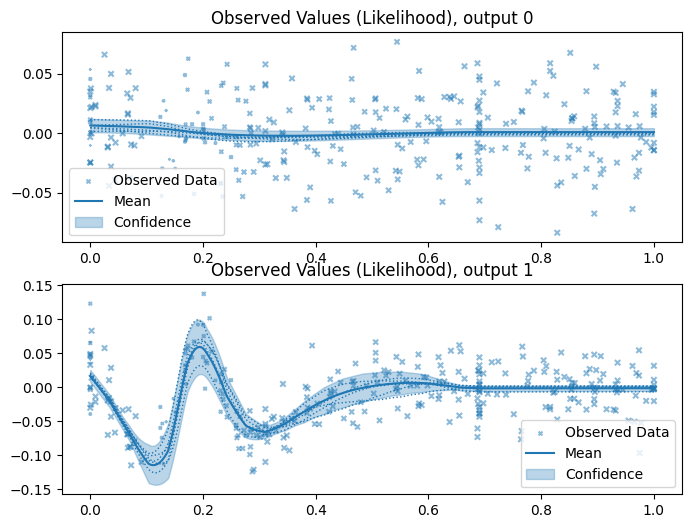

In [19]:
num_samples = 5
use_likelihood = False

num_points_between_samples = 30
t_lin = np.linspace(0, 1, num_points_between_samples, endpoint=False)

x_plot_waypts = np.hstack((X_init[1:, :], U_init))
x_plot = []
for i in range(x_plot_waypts.shape[0] - 1):
    x_plot += [
        x_plot_waypts[i, :] + (x_plot_waypts[i + 1, :] - x_plot_waypts[i, :]) * t
        for t in t_lin
    ]
x_plot = np.vstack(x_plot)

gp_data = gp_data_from_model_and_path(
    gp_model, likelihood, x_plot, num_samples=num_samples, use_likelihood=use_likelihood
)
plot_gp_data([gp_data], marker_size_lim=[1, 15])

We can also plot the derivative of the GP. Note that the projected Jacobian is not smooth since our path is not smooth either (jump projection direction = jump in Jacobian); however, the actual Jacobian should be smooth here (squared exponential kernel).

(<Figure size 800x600 with 2 Axes>,
 array([<Axes: title={'center': 'Observed Values (Likelihood), output 0'}>,
        <Axes: title={'center': 'Observed Values (Likelihood), output 1'}>],
       dtype=object))

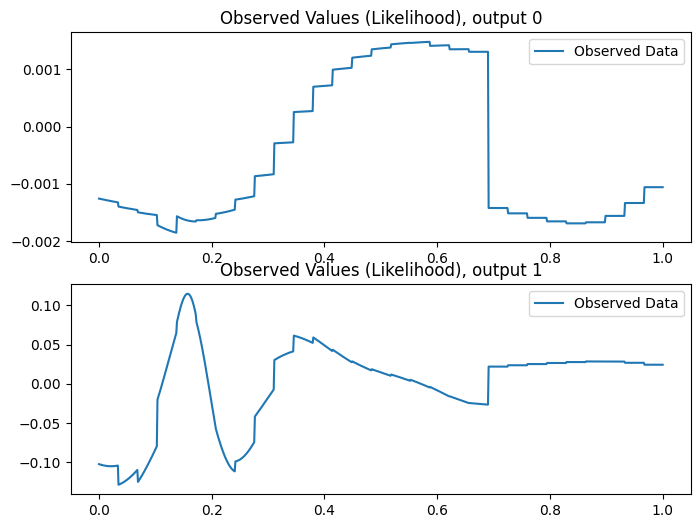

In [20]:
gp_derivative_data = gp_derivative_data_from_model_and_path(
    gp_model, likelihood, x_plot, num_samples=0
)
plot_gp_data([gp_derivative_data], marker_size_lim=[5, 20], plot_train_data=False)

Compare with plotting along a slice of the dimension. Since we generated training data along the path of the robustified controller, the GP looks pretty untrained along a slice of the coordinates.

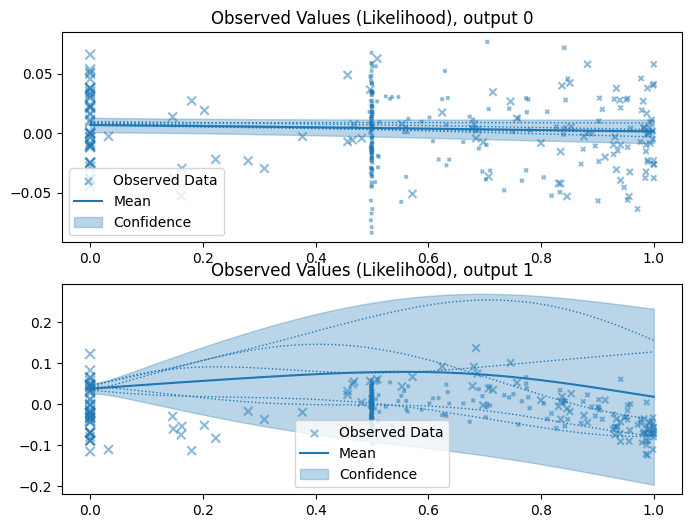

In [21]:
# plot along axis
x_dim_lims = np.array([[0, np.pi], [-2, 1], [-2, 2]])
x_dim_slice = np.array([1 * np.pi, 0, 0])
x_dim_plot = 2
x_grid = generate_grid_points(x_dim_lims, x_dim_slice, x_dim_plot, num_points=800)

gp_grid_data = gp_data_from_model_and_path(
    gp_model, likelihood, x_grid, num_samples=num_samples, use_likelihood=use_likelihood
)
fig, ax = plot_gp_data([gp_grid_data], marker_size_lim=[5, 50])

y_lim_0 = ax[0].get_ylim()
y_lim_1 = ax[1].get_ylim()

Jacobian... not much going on away from the data points (this is good!)

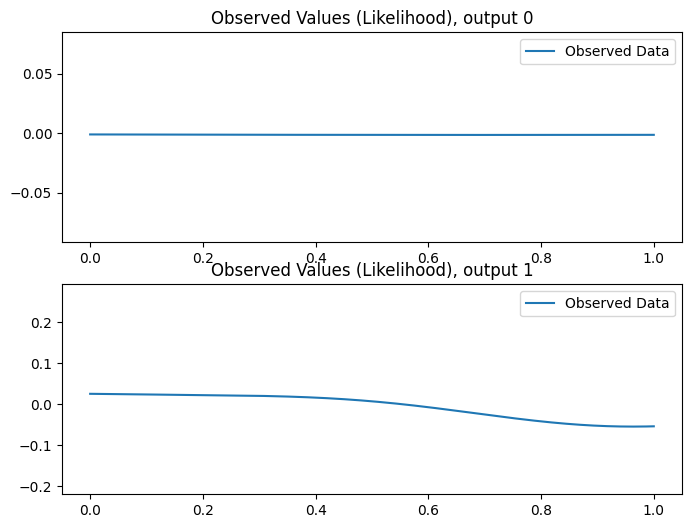

In [22]:
gp_derivative_grid_data = gp_derivative_data_from_model_and_path(
    gp_model, likelihood, x_grid, num_samples=0
)
fig, ax = plot_gp_data(
    [gp_derivative_grid_data], marker_size_lim=[5, 50], plot_train_data=False
)

ax[0].set_ylim(*y_lim_0)
ax[1].set_ylim(*y_lim_1)
plt.draw()

# Residual-Model MPC

In [23]:
from zero_order_gpmpc.models.residual_model import ResidualModel

In [24]:
class ResidualGPyTorch(ResidualModel):
    def __init__(self, gpytorch_model):
        self.gp_model = gpytorch_model
        if gp_model.train_inputs[0].device.type == "cuda":
            self.to_tensor = lambda X: torch.Tensor(X).cuda()
            self.to_numpy = lambda T: T.cpu().detach().numpy()
        else:
            self.to_tensor = lambda X: torch.Tensor(X)
            self.to_numpy = lambda T: T.detach().numpy()

        if torch.cuda.is_available():
            self.cuda_is_available = True
        else:
            self.cuda_is_available = False

        def mean_fun_sum(y):
            with gpytorch.settings.fast_pred_var():
                return gp_model(y).mean.sum(dim=0)

        self._mean_fun_sum = mean_fun_sum

    def evaluate(self, y):
        with gpytorch.settings.fast_pred_var():
            y_tensor = torch.autograd.Variable(self.to_tensor(y), requires_grad=False)
            with torch.no_grad():
                self.predictions = gp_model(y_tensor)
        return self.to_numpy(self.predictions.mean)

    def jacobian(self, y):
        with gpytorch.settings.fast_pred_var():
            y_tensor = torch.autograd.Variable(self.to_tensor(y), requires_grad=True)
            mean_dy = torch.autograd.functional.jacobian(self._mean_fun_sum, y_tensor)
        return self.to_numpy(mean_dy)

    def value_and_jacobian(self, y):
        with gpytorch.settings.fast_pred_var():
            y_tensor = torch.autograd.Variable(self.to_tensor(y), requires_grad=True)
            with torch.no_grad():
                self.predictions = gp_model(y_tensor)
            mean_dy = torch.autograd.functional.jacobian(self._mean_fun_sum, y_tensor)

        self.current_mean = self.to_numpy(self.predictions.mean)
        self.current_variance = self.to_numpy(self.predictions.variance)
        self.current_mean_dy = self.to_numpy(mean_dy)

        return self.current_mean, self.current_mean_dy

In [25]:
residual_model = ResidualGPyTorch(gp_model)

In [26]:
residual_model.evaluate(x_plot_waypts[0:3, :])

array([[ 0.00652427,  0.0163695 ],
       [ 0.00606629, -0.02053305],
       [ 0.00550909, -0.06737503]], dtype=float32)

In [27]:
residual_model.jacobian(x_plot_waypts[0:3, :])

array([[[ 0.00089437,  0.00107572, -0.00104834],
        [ 0.00091862,  0.00113921, -0.00106003],
        [ 0.00094876,  0.0011921 , -0.00107185]],

       [[ 0.21649827,  0.05215717,  0.0283123 ],
        [ 0.20826702,  0.0558675 ,  0.03083088],
        [ 0.18331562,  0.04447127,  0.03321227]]], dtype=float32)

In [28]:
residual_model.value_and_jacobian(x_plot_waypts[0:3, :])

(array([[ 0.00652427,  0.0163695 ],
        [ 0.00606629, -0.02053305],
        [ 0.00550909, -0.06737503]], dtype=float32),
 array([[[ 0.00089437,  0.00107572, -0.00104834],
         [ 0.00091862,  0.00113921, -0.00106003],
         [ 0.00094876,  0.0011921 , -0.00107185]],
 
        [[ 0.21649827,  0.05215717,  0.0283123 ],
         [ 0.20826702,  0.0558675 ,  0.03083088],
         [ 0.18331562,  0.04447127,  0.03321227]]], dtype=float32))

In [29]:
residual_mpc = ResidualLearningMPC(
    copy.deepcopy(ocp_init),
    copy.deepcopy(sim),
    residual_model=residual_model,
    use_cython=False,
    path_json_ocp="residual_mpc_ocp_solver_config.json",
    path_json_sim="residual_mpc_sim_solver_config.json",
    build_c_code=True,
)

 If there is an incompatibility with the CasADi generated code, please consider changing your CasADi version.
Version 3.6.5 currently in use.
rm -f libacados_ocp_solver_linear_model_with_params_nx2_nu1_np0.so
rm -f linear_model_with_params_nx2_nu1_np0_constraints/linear_model_with_params_nx2_nu1_np0_constr_h_fun_jac_uxt_zt.o linear_model_with_params_nx2_nu1_np0_constraints/linear_model_with_params_nx2_nu1_np0_constr_h_fun.o acados_solver_linear_model_with_params_nx2_nu1_np0.o
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-package-experimental/external/acados/include/hpipm/include  -c -o linear_model_with_params_nx2_nu1_np0_constraints/linear_model_with_params_nx2_nu1_np0_constr_h_

In [30]:
for i in range(N):
    residual_mpc.ocp_solver.set(i, "x", X_init[i, :])
    residual_mpc.ocp_solver.set(i, "u", U_init[i, :])
residual_mpc.ocp_solver.set(N, "x", X_init[N, :])

residual_mpc.solve()
X_res, U_res = residual_mpc.get_solution()

initing 30 solve stat fields
residuals after  0 SQP_RTI iterations:
 [2.61799388e+00 8.71868345e-02 8.51960247e-01 9.90552334e-09]
residuals after  1 SQP_RTI iterations:
 [2.98861288e-01 2.07141870e-02 8.71901818e-01 9.17082274e-09]
residuals after  2 SQP_RTI iterations:
 [1.66767191e-01 4.39642131e-02 9.76469365e-01 1.00219555e-09]
residuals after  3 SQP_RTI iterations:
 [2.27962603e-01 4.85534336e-02 1.19328284e+00 5.90836699e-09]
residuals after  4 SQP_RTI iterations:
 [2.15287355e-01 9.65568581e-02 1.26672694e+00 8.12294629e-09]
residuals after  5 SQP_RTI iterations:
 [2.48278458e-01 6.25304461e-02 1.37516136e+00 1.76871153e-09]
residuals after  6 SQP_RTI iterations:
 [2.31118896e-01 1.25841059e-01 1.36247647e+00 3.75649099e-09]
residuals after  7 SQP_RTI iterations:
 [2.38926947e-01 5.88036667e-02 1.33888914e+00 2.67492244e-09]
residuals after  8 SQP_RTI iterations:
 [2.28305242e-01 1.19819102e-01 1.34400601e+00 3.84798687e-09]
residuals after  9 SQP_RTI iterations:
 [2.42489380e-

In [31]:
X_res_sim = np.zeros_like(X_res)
X_res_sim[0, :] = x0
for i in range(N):
    acados_integrator_actual.set("x", X_res_sim[i, :])
    acados_integrator_actual.set("u", U_res[i, :])
    acados_integrator_actual.solve()
    X_res_sim[i + 1, :] = acados_integrator_actual.get("x")

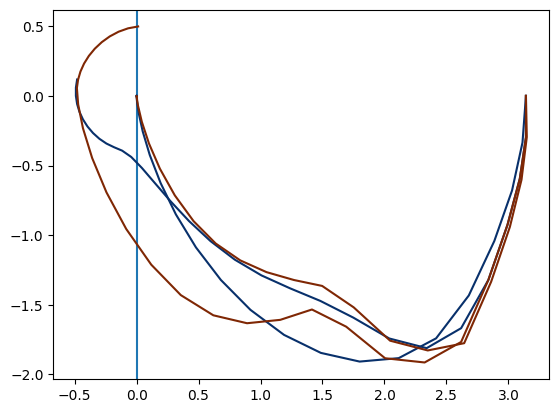

In [32]:
lb_theta = -ocp_init.constraints.lh[0]
fig, ax = base_plot(lb_theta=lb_theta)

plot_data_res = EllipsoidTubeData2D(center_data=X_res, ellipsoid_data=None)
plot_data_res_sim = EllipsoidTubeData2D(center_data=X_res_sim, ellipsoid_data=None)
add_plot_trajectory(ax, plot_data_nom, prob_tighten=None, color_fun=plt.cm.Blues)
add_plot_trajectory(ax, plot_data_nom_sim, prob_tighten=None, color_fun=plt.cm.Blues)
add_plot_trajectory(ax, plot_data_res, prob_tighten=None, color_fun=plt.cm.Oranges)
add_plot_trajectory(ax, plot_data_res_sim, prob_tighten=None, color_fun=plt.cm.Oranges)